In [1]:
import os
import numpy as np
import pandas as pd
from debiasm.sklearn_functions import AdaptationDebiasMClassifier, \
                                            DebiasMClassifier
from debiasm.torch_functions import rescale
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import jensenshannon
import torch
from sklearn.model_selection import cross_val_score
from debiasm.sklearn_functions import batch_weight_feature_and_nbatchpairs_scaling
import subprocess

In [ ]:
def set_up_eval(samples_,
                   n_studies, 
                   n_per_study,
                   n_features,
                   phenotype_std,
                   read_depth, 
                   smp_noise_lvl=0,
                   bcf_stdv = 2, 
                   linear_weights_stdv = 2,
                   seed=0):
    
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    
    # drop samples/features not needed for this run
    samples=samples_.sample(n=n_studies * n_per_study)\
                .T.sample(n=n_features).T
    
    ## simulated bcfs
    true_bcfs = np.random.normal(scale=bcf_stdv,
                                 size = (n_studies, n_features)
                                 )
    
    ## simulated linear weights
    true_weights = np.random.normal(scale=linear_weights_stdv, 
                                    size = n_features
                                    )

    ## simulated phenotypes
    phenotypes_ = samples @ true_weights[:, np.newaxis]
    if phenotype_std > 0:
        phenotypes_ += np.random.normal(scale = phenotype_std,
                                       size=phenotypes_.shape)
    
    studies = pd.Series( [ i // n_per_study for i in range(samples.shape[0]) 
                                     ] , 
                        index=samples.index, 
                        name='studies')

    samples_transformed = rescale(samples.values *\
                                    np.power(2, true_bcfs)[studies] 
                                    )
    
    samples_transformed = samples_transformed + \
                                smp_noise_lvl * ( \
                                np.random.rand(*samples_transformed.shape) ) ## range \in [0,1]
    
#     samples_transformed = samples_transformed + np.random.lognormal(loc=0)
    
    
    samples_transformed[ samples_transformed< 0 ]=0 ## zero out anything <0
    
    samples_transformed = ( rescale(samples_transformed) *read_depth ).astype(int)
    
    samples_transformed = pd.DataFrame(samples_transformed,
                                       index=samples.index, 
                                       columns=samples.columns)
        
#     dm = AdaptationDebiasMClassifier()
    test_set_inds = studies==studies.max()
    train_set_inds = studies!=studies.max()
    
    phenotypes = phenotypes_.loc[train_set_inds]
    df_with_batch = pd.concat([studies, samples_transformed], axis=1 )
    
    dm = DebiasMClassifier(x_val = df_with_batch.loc[test_set_inds].values, 
                           batch_str = batch_weight_feature_and_nbatchpairs_scaling(1e4, 
                                                                                    df_with_batch)
                          )
    dm.fit(X=df_with_batch.loc[train_set_inds].values, 
           y=phenotypes.values[:, 0] > phenotypes.median().values[0]    
          )
    
    
    
    transformed_jsds = jensenshannon( dm.transform(pd.concat([studies,
                                      samples_transformed], 
                                      axis=1 )
                                          ).T,
                              samples.T)

    baseline_jsds = jensenshannon(samples_transformed.T, samples.T)
    n_samples = samples.shape[0]

    summary_df = pd.DataFrame({'Group':['Baseline']*n_samples +\
                                               ['DEBIAS-M']*n_samples,
                               'JSD':list(baseline_jsds**2) +\
                                           list(transformed_jsds**2),
                               'N_studies':n_studies, 
                               'N_per_study':n_per_study, 
                               'N_features':n_features, 
                               'Pheno_noise':phenotype_std, 
                               'Read_depth':read_depth, 
                               'BCF_std':bcf_stdv,
                               'Micro_noise':smp_noise_lvl,
                               'is_test_set':list(test_set_inds.values)*2,
                               'run_num':seed
                              })
    
    run_description = '_'.join( [a.replace('_', '-') + '-' + str(b)
                                 for a,b in 
                                   {'N_studies':n_studies, 
                                   'N_per_study':n_per_study, 
                                   'N_features':n_features, 
                                   'Pheno_noise':phenotype_std, 
                                   'Read_depth':int(read_depth), 
                                   'BCF_std':bcf_stdv,
                                    'Micro_noise':smp_noise_lvl,
                                   'run_num':seed}.items()]
                                )
    
    return(summary_df, 
           run_description, 
           true_bcfs, 
           dm, 
           samples, 
           samples_transformed, 
           phenotypes_.iloc[:, 0] > np.median( phenotypes_.values[:, 0] ), 
           studies, 
           test_set_inds
           )



In [2]:

def quantify_experiment_signal_noise(samples_,
                               n_studies, 
                               n_per_study,
                               n_features,
                               phenotype_std,
                               read_depth, 
                               smp_noise_lvl=1e-5,
                               bcf_stdv = 2, 
                               linear_weights_stdv = 2,
                               seed=0):
    
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    
    # drop samples/features not needed for this run
    samples=samples_.sample(n=n_studies * n_per_study)\
                .T.sample(n=n_features).T
    
    ## simulated bcfs
    true_bcfs = np.random.normal(scale=bcf_stdv,
                                 size = (n_studies, n_features)
                                 )
    
    ## simulated linear weights
    true_weights = np.random.normal(scale=linear_weights_stdv, 
                                    size = n_features
                                    )

    ## simulated phenotypes
    phenotypes = samples @ true_weights[:, np.newaxis]
    if phenotype_std > 0:
        phenotypes_prenoise=phenotypes.copy()
        phenotypes += np.random.normal(scale = phenotype_std,
                                       size=phenotypes.shape)
    
    studies = pd.Series( [ i // n_per_study for i in range(samples.shape[0]) 
                                     ] , 
                        index=samples.index, 
                        name='studies')

    samples_transformed = rescale(samples *\
                                    np.power(2, true_bcfs)[studies] 
                                    )
    
    samples_transformed = samples_transformed + \
                                ( smp_noise_lvl * ( \
                                  np.random.rand(*samples_transformed.shape) ) *
                                 ( samples_transformed>0 )
                                )
                        
        
    ## range \in [-1,1]
    samples_transformed[ samples_transformed< 0 ]=0 ## zero out anything <0
    
    
    return(rescale( samples_transformed ), 
           phenotypes, 
           phenotypes_prenoise, 
           true_weights, 
           true_bcfs)

In [3]:
from sklearn.metrics import r2_score

In [4]:
from sklearn.metrics import roc_auc_score

In [5]:
# noise_inv_r2s

In [6]:
from scipy.stats import spearmanr

In [7]:
# phen.values[:, 0]/

In [8]:
# ( qweqwe @ tws ).values

In [10]:
# spearmanr( phen.values[:, 0], 
#          ( qweqwe @ tws ).values
#         ).correlation

In [107]:
np.logspace(-4, 0, 5)

array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])

In [11]:
%%time
investigation_noises=[]
noise_inv_r2s=[]

for n_features in [100]:
    for n_studies in [4]:
        for n_per_study in [96]:
            for read_depth in [1e5]:
                for phenotype_std in [.1]:
                    for smp_noise_lvl_ in [0, 0.001,  0.01, 0.05, 0.1]:#np.logspace(-4, 0, 5):
                        if ( n_features == 100 ) or \
                           ( n_studies == 4 ) or \
                           ( read_depth == 1e4 ) or \
                           ( n_per_study == 96 ) or \
                           ( phenotype_std == .1 ): 

                            for seed in range(1,26):
                                data = pd.read_csv('../Simulations/generated-100-feat-datasets/dataset-seed-{}.csv'.format(seed), 
                                                  index_col=0)
#                                 results, run_desc = experiment_run_with_sample_noise(data,
#                                                                        n_studies, 
#                                                                        n_per_study,
#                                                                        n_features,
#                                                                        phenotype_std,
#                                                                        read_depth, 
#                                                                        smp_noise_lvl=smp_noise_lvl_,
#                                                                        bcf_stdv = 2, 
#                                                                        seed=seed
#                                                                        )
                                smpt, phen, phenpm, tws, tbfcs = quantify_experiment_signal_noise(data,
                                                                              n_studies, 
                                                                              n_per_study,
                                                                              n_features,
                                                                              phenotype_std,
                                                                              read_depth, 
                                                                              smp_noise_lvl=smp_noise_lvl_,
                                                                              bcf_stdv = 2, 
                                                                              seed=seed
                                                                              )
    
                                qweqwe=rescale( smpt * np.power(2, 
                                    -tbfcs[pd.Series( [ i // n_per_study 
                                                       for i in range(smpt.shape[0])  ] , 
                                                        index=smpt.index, 
                                                        name='studies')] ) )

#                                 qweqwe=smpt

                                noise_inv_r2s.append(r2_score( phen.values[:, 0], 
                                                             ( qweqwe @ tws ).values
                                                             ))
                            
#                                 noise_inv_r2s.append(r2( phen.values[:, 0] > np.median(phenpm.values[:, 0]), 
#                                                       ( qweqwe @ tws ).values
#                                                      ))

                                investigation_noises.append(smp_noise_lvl_)
                                

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/p

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/p

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/p

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/p

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/p

CPU times: user 5.03 s, sys: 2.08 s, total: 7.11 s
Wall time: 2.25 s


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/p

In [12]:
import sys
sys.path.append('../v1-DEBIAS-M-Analysis/General_functions/')
from plotting import global_palette

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 64.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


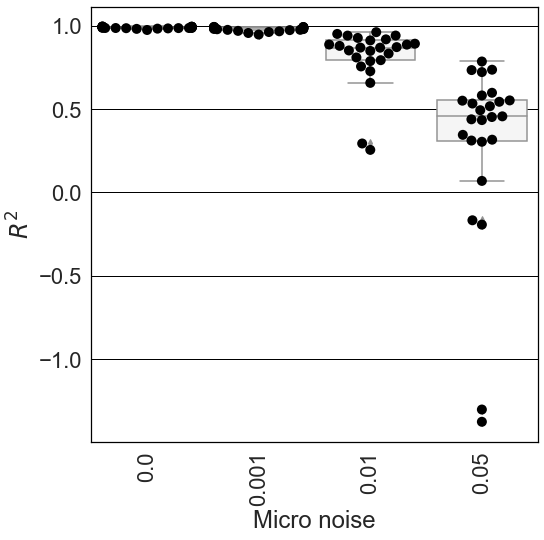

In [21]:
plt.figure(figsize=(8,8))
ax=sns.boxplot(y=noise_inv_r2s, 
               x=np.array(investigation_noises).astype(str), 
               color='whitesmoke',
               order=[str(a) for a in [0., 1e-3, 1e-2, 0.05]]
               )
sns.swarmplot(y=noise_inv_r2s, 
              x=np.array(investigation_noises).astype(str), 
              color='black', 
              s=10, 
              order=[str(a) for a in [0., 1e-3, 1e-2, 0.05]],
              ax=ax
              )
plt.xlabel('Micro noise')
plt.ylabel('$R^2$')
plt.xticks(rotation=90)
# plt.ylim([0,1])

# plt.yticks(np.linspace(.2, 1, 5))

out_path = '../results/All-methods-revision-simulations/Noise-impact.pdf'
plt.savefig(out_path, 
            dpi=900,
            bbox_inches='tight', 
            format='pdf')
plt.show()



In [132]:
import os
import numpy as np
import pandas as pd
from debiasm.sklearn_functions import AdaptationDebiasMClassifier, \
                                            DebiasMClassifier
from debiasm.torch_functions import rescale
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import jensenshannon
import torch
from sklearn.model_selection import cross_val_score
from debiasm.sklearn_functions import batch_weight_feature_and_nbatchpairs_scaling
import subprocess
def experiment_run(samples_,
                   n_studies, 
                   n_per_study,
                   n_features,
                   phenotype_std,
                   read_depth, 
                   smp_noise_lvl=0,
                   bcf_stdv = 2, 
                   linear_weights_stdv = 2,
                   seed=0):
    
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    
    # drop samples/features not needed for this run
    samples=samples_.sample(n=n_studies * n_per_study)\
                .T.sample(n=n_features).T
    
    ## simulated bcfs
    true_bcfs = np.random.normal(scale=bcf_stdv,
                                 size = (n_studies, n_features)
                                 )
    
    ## simulated linear weights
    true_weights = np.random.normal(scale=linear_weights_stdv, 
                                    size = n_features
                                    )

    ## simulated phenotypes
    phenotypes_ = samples @ true_weights[:, np.newaxis]
    if phenotype_std > 0:
        phenotypes_ += np.random.normal(scale = phenotype_std,
                                       size=phenotypes_.shape)
    
    studies = pd.Series( [ i // n_per_study for i in range(samples.shape[0]) 
                                     ] , 
                        index=samples.index, 
                        name='studies')

    samples_transformed = rescale(samples.values *\
                                    np.power(2, true_bcfs)[studies] 
                                    )
    
    samples_transformed = samples_transformed + \
                                ( smp_noise_lvl * ( \
                                  np.random.rand(*samples_transformed.shape) ) *
                                 ( samples_transformed>0 )
                                )
    
#     samples_transformed = samples_transformed + np.random.lognormal(loc=0)
    
    
    samples_transformed[ samples_transformed< 0 ]=0 ## zero out anything <0
    
    samples_transformed = ( rescale(samples_transformed) *read_depth ).astype(int)
    
    samples_transformed = pd.DataFrame(samples_transformed,
                                       index=samples.index, 
                                       columns=samples.columns)
    
    test_set_inds = studies==studies.max()
    train_set_inds = studies!=studies.max()
    
    phenotypes = phenotypes_.loc[train_set_inds]
    df_with_batch = pd.concat([studies, samples_transformed], axis=1 )
    
    dm = DebiasMClassifier(x_val = df_with_batch.loc[test_set_inds].values, 
                           batch_str = batch_weight_feature_and_nbatchpairs_scaling(1e4, 
                                                                                    df_with_batch)
                          )
    dm.fit(X=df_with_batch.loc[train_set_inds].values, 
           y=phenotypes.values[:, 0] > phenotypes.median().values[0]    
          )
    
    
    
    transformed_jsds = jensenshannon( dm.transform(pd.concat([studies,
                                      samples_transformed], 
                                      axis=1 )
                                          ).T,
                              samples.T)

    baseline_jsds = jensenshannon(samples_transformed.T, samples.T)
    n_samples = samples.shape[0]

    summary_df = pd.DataFrame({'Group':['Baseline']*n_samples +\
                                               ['DEBIAS-M']*n_samples,
                               'JSD':list(baseline_jsds**2) +\
                                           list(transformed_jsds**2),
                               'N_studies':n_studies, 
                               'N_per_study':n_per_study, 
                               'N_features':n_features, 
                               'Pheno_noise':phenotype_std, 
                               'Read_depth':read_depth, 
                               'BCF_std':bcf_stdv,
                               'Micro_noise':smp_noise_lvl,
                               'is_test_set':list(test_set_inds.values)*2,
                               'run_num':seed
                              })
    
    run_description = '_'.join( [a.replace('_', '-') + '-' + str(b)
                                 for a,b in 
                                   {'N_studies':n_studies, 
                                   'N_per_study':n_per_study, 
                                   'N_features':n_features, 
                                   'Pheno_noise':phenotype_std, 
                                   'Read_depth':int(read_depth), 
                                   'BCF_std':bcf_stdv,
                                    'Micro_noise':smp_noise_lvl,
                                   'run_num':seed}.items()]
                                )
    
    return(summary_df, 
           run_description, 
           true_bcfs, 
           dm, 
           samples, 
           samples_transformed, 
           phenotypes_.iloc[:, 0] > np.median( phenotypes_.values[:, 0] ), 
           studies, 
           test_set_inds
           )


In [141]:

    
all_results = []
if True:
    for seed in range(1,26):
        for n_features in [100]:
            for n_studies in [4]:
                for n_per_study in [96]:
                    for read_depth in [ 1e4 ]:
                        for phenotype_std in [.1]:
                            for smp_noise_lvl_ in [0, 0.001,  0.01, 0.05, 0.1]:
                                
                                if  (\
                                    ( n_features == 100 ) + \
                                    ( n_studies == 4 ) + \
                                    ( read_depth == 1e4 ) + \
                                    ( n_per_study == 96 ) + \
                                    ( phenotype_std == .1 ) + \
                                    (smp_noise_lvl_ == 0 )\
                                      )>= 5: 

                                
                                    print(seed)
                                    data = pd.read_csv('../Simulations/generated-100-feat-datasets/dataset-seed-{}.csv'.format(seed), 
                                                      index_col=0)
                                    
                                    if n_features==10:
                                        data = data + 1e-4

                                    summary_df, \
                                       run_description,\
                                       true_bcfs, \
                                       dm, \
                                       samples, \
                                       samples_transformed, \
                                       y, \
                                       studies, \
                                       test_set_inds = experiment_run(data,
                                                                n_studies, 
                                                                n_per_study,
                                                                n_features,
                                                                phenotype_std,
                                                                read_depth, 
                                                                bcf_stdv = 2, 
                                                                seed=seed, 
                                                                smp_noise_lvl=smp_noise_lvl_     
                                                                )
                                    
                                    all_results.append(summary_df)

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/U

1


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

1


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

1


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

1


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

2


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/U

2


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

2


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

2


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

3


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/U

3


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

3


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

3


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

3


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

4


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

4


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

4


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

4


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_ra

5


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

5


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

5


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

6


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/U

6


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

6


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

6


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

6


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

7


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in 

7


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

8


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

8


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

8


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/U

9


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

9


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

9


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

9


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

11


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/py

12


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

12


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

12


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

12


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

13


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

13


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

13


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

13


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

13


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

14


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_cal

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_cal

14


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/U

14


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

15


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

15


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

15


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

15


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

15


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

16


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

16


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

16


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

16


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

16


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

17


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

17


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

17


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

17


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

17


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

18


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

18


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

18


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

18


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

18


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

19


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

19


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

19


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

19


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

19


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

20


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

20


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

20


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

20


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

20


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

21


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

21


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

21


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

21


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

21


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

22


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

22


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

22


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

22


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/U

23


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

23


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

23


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/U

23


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

24


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

24


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

24


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

24


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

24


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

25


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

25


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

25


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

25


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

25


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

In [130]:
global_palette['Baseline'] = global_palette['linear']
global_palette['DEBIAS-M'] = global_palette['debias-m']

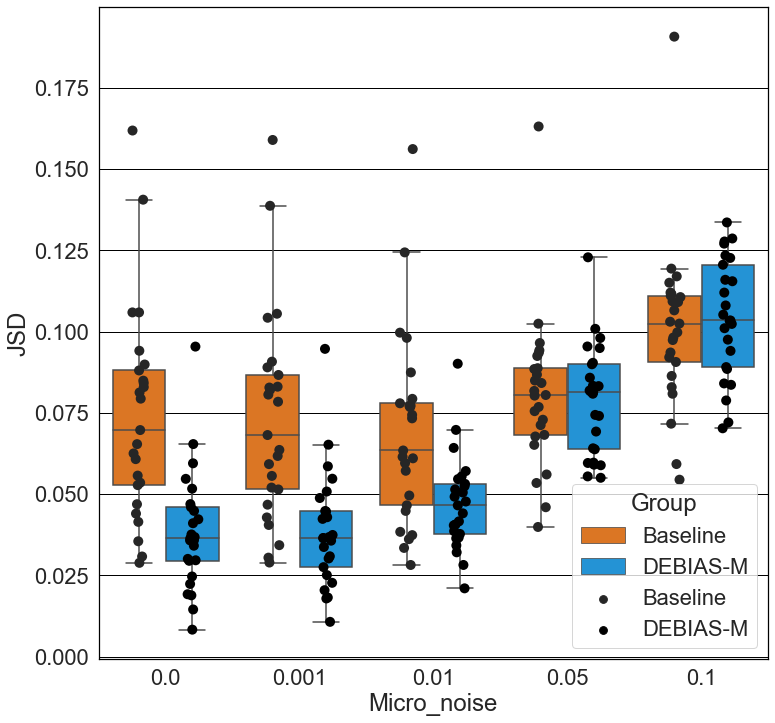

In [142]:
df_tmp = pd.concat(all_results)
df_tmp=df_tmp.loc[df_tmp.is_test_set]
col_of_interest='Micro_noise'

df_tmp = df_tmp.groupby( list( df_tmp.columns.drop('JSD').values) 
                           )['JSD'].median().reset_index()

plt.figure(figsize=(12, 12))
# plt.semilogy()
ax=sns.boxplot(hue='Group', 
            x = col_of_interest,
            y = 'JSD', 
            data=df_tmp, 
            palette=global_palette,
            fliersize=0)
# plt.show()

sns.stripplot(hue ='Group', 
              x = col_of_interest,
              y = 'JSD', 
              data=df_tmp, 
              color='black',
              s=10, 
              ax=ax, 
              dodge=True
              )
plt.show()
